In [85]:
# Imports
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from IPython.display import YouTubeVideo
import numpy as np
import pandas as pd
from scipy import signal
from scipy.integrate import cumulative_trapezoid
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample

In [86]:
# Convenience function that creates both a time domain and frequency domain plot.
def plot_time_freq(t, y):
    # Converts Data into Frequncy Domain
    freq = np.fft.fftfreq(t.size, d=t[1]-t[0])
    Y = abs(np.fft.fft(y))
    
    # Time domain plot
    plt.figure(figsize = [14,3])
    plt.subplot(1,2,1)
    plt.plot(t,y)
    plt.title('Time Domain')
    plt.xlabel('Time')
    plt.ylabel('Signal')
    
    # Frequency domain plot
    plt.subplot(1,2,2)
    markerline, stemline, baseline = plt.stem(np.fft.fftshift(freq),np.fft.fftshift(Y),
                                              'k', markerfmt='tab:orange')
    plt.setp(stemline, linewidth = 1.5)
    plt.setp(markerline, markersize = 4)
    plt.title('Frequency Domain')
    plt.xlabel('Frequency')
    plt.xlim(-20, 20)
    plt.ylabel('Absolute FFT')
    plt.grid()

    plt.tight_layout()
    plt.show()

def fourierPrediction(y, n_predict, n_harm = 5):
    n = y.size                         # length of the time series
    t = np.arange(0, n)                # time vector
    p = np.polyfit(t, y, 1)            # find linear trend in x
    y_notrend = y - p[0] * t - p[1]    # detrended x
    y_freqdom = np.fft.fft(y_notrend)  # detrended x in frequency domain
    f = np.fft.fftfreq(n)              # frequencies
    
    # Sort indexes by largest frequency components
    indexes = np.argsort(np.absolute(y_freqdom))[::-1]

    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        amp = np.absolute(y_freqdom[i]) / n   # amplitude
        phase = np.angle(y_freqdom[i])        # phase
        restored_sig += amp * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t + p[1] # add back the trend

def fourierPredictionPlot(y, prediction):
    plt.figure(figsize=(10, 3))
    plt.plot(np.arange(0, y.size), y, 'k', label = 'data', linewidth = 2, alpha=0.5)
    plt.plot(np.arange(0, prediction.size), prediction, 'tab:red', label = 'prediction')
    plt.grid()
    plt.legend()
    plt.show()

### Exercise 1

- Combine (add) the [sine, trend, and noise](#signal-with-trend-and-noise) we defined earlier and obtain a singal composed of:
    * A sine wave representing seasonality.
    * a parabolic function representing a trend.
    * and uniformly distributed random noise.
- Plot the time and frequency domain components.
- Modify the amplitude of the sine, trend, and noise components so that each component, in turn, dominates over the others. Comment on how the FT of the total signal changes.
- Modify the sine into a signal that is the sum of 2 sine waves of different amplitudes at 1 and 10 Hz as well as a constant term.  Make a plot in both time and frequency domains and comment the results.

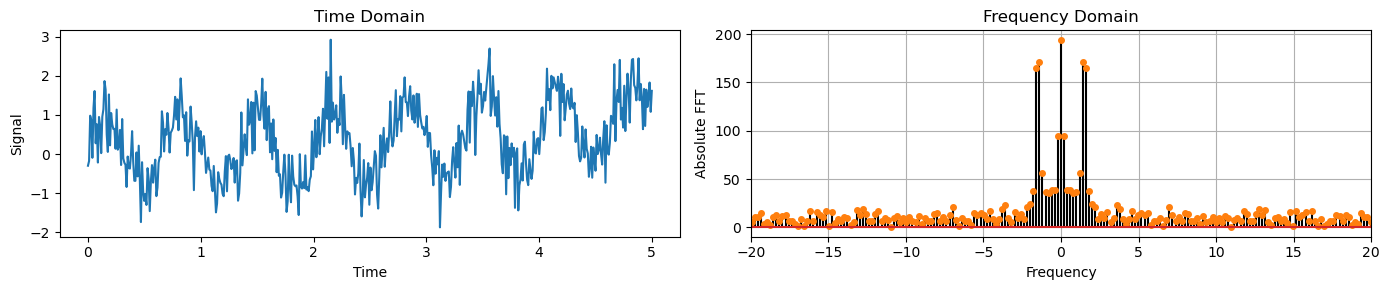

In [87]:
time = np.linspace(0, 5, 512)
freq = 1.5

# Generate seasonality
y_sine = np.sin(2 * np.pi * freq * time)

# Generate trend
y_trend = (0.2 * time)**2

# Generate noise
y_noise = 0.5 * np.random.randn(len(time))

# Sum up the components
y = y_sine + y_trend + y_noise
plot_time_freq(time, y)

Case 1: Seasonal component dominates over trend and resitual

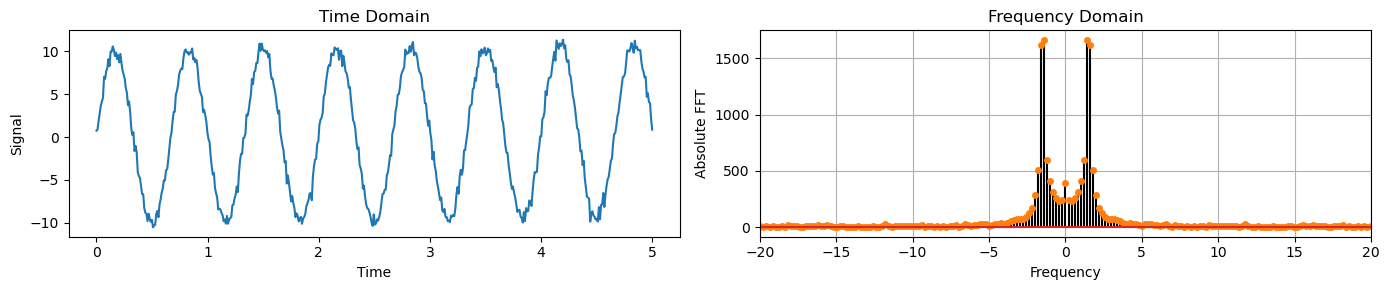

In [88]:
time = np.linspace(0, 5, 512)
freq = 1.5

# Generate seasonality
y_sine = 10*np.sin(2 * np.pi * freq * time)

# Generate trend
y_trend = (0.2 * time)**2

# Generate noise
y_noise = 0.5 * np.random.randn(len(time))

# Sum up the components
y = y_sine + y_trend + y_noise
plot_time_freq(time, y)

Fourier transform is linear: 
$$\mathcal{F}\{a f(t) + b g(t)\} = a \mathcal{F}\{f(t)\} + b \mathcal{F}\{g(t)\}$$

 This means that, when scaling the seasonal component in the time domain by a constant K, the frequency spikes in the fourier domains will be scaled by the same constant. In our case:
 $$\mathcal{F}\{K f_s(t) + f_t(t) + f_n(t)\} = K \mathcal{F}\{f_s(t)\} + \mathcal{F}\{f_t(t)\} + \mathcal{F}\{f_n(t)\}$$

 Where $f_s, f_t, f_n$ are the seasonal, trend, and noise components.
 Above plot shows in fact how the two spikes in the frequency graph produced by the seasonal sine wave are scaled exactly by a factor of $K=10$ with respect to the precious case.

 - By applyng the same scaling factor to noise and trend respectively, We expect to see:
  1) The spike around the 0 frequency to be scaled when the trend is scaled
  2) A normally distributed collection of spikes in all frequency will be scaled when noise is scaled.

Plots below shows such behaviour:

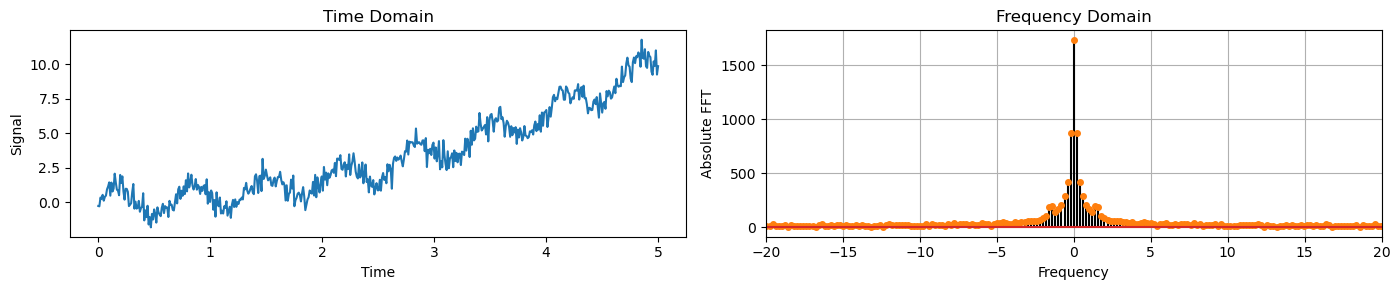

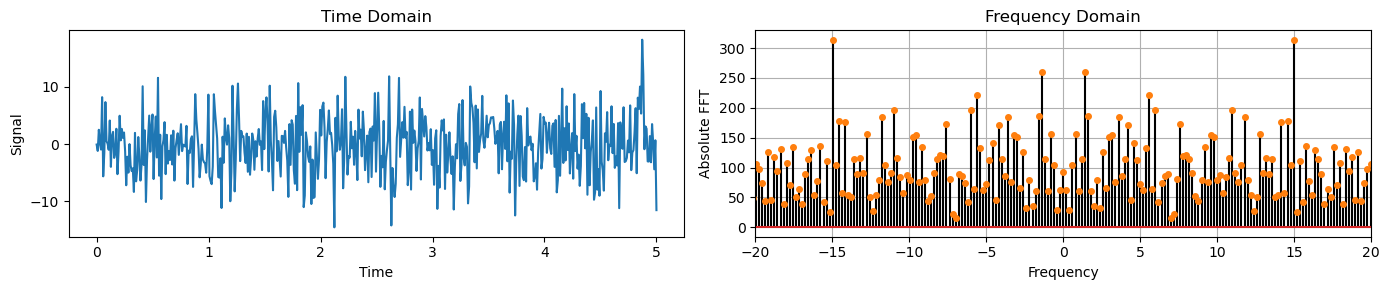

In [89]:
time = np.linspace(0, 5, 512)
freq = 1.5

# Generate seasonality
y_sine = np.sin(2 * np.pi * freq * time)
# Generate trend
y_trend = 10*(0.2 * time)**2
# Generate noise
y_noise = 0.5 * np.random.randn(len(time))

# Sum up the components
y = y_sine + y_trend + y_noise
plot_time_freq(time, y)

# Generate seasonality
y_sine = np.sin(2 * np.pi * freq * time)
# Generate trend
y_trend = (0.2 * time)**2
# Generate noise
y_noise = 5 * np.random.randn(len(time))

# Sum up the components
y = y_sine + y_trend + y_noise
plot_time_freq(time, y)

Let's now address the last point:

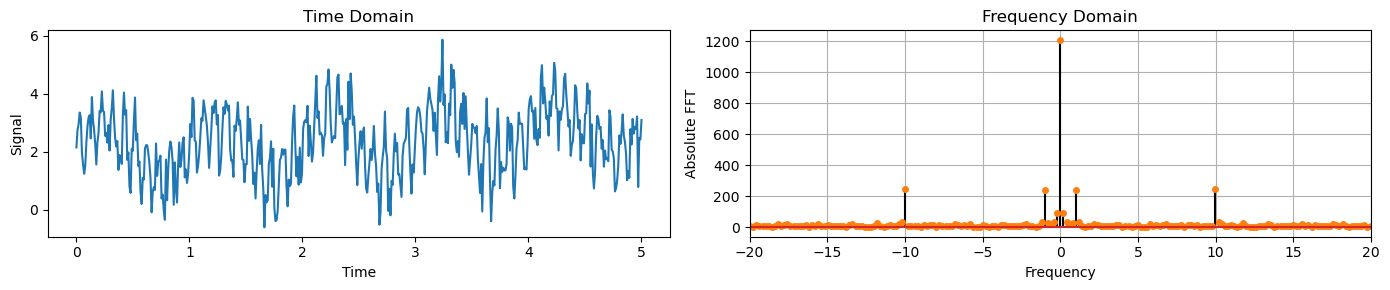

In [90]:
# Generate seasonality
y_sine = np.sin(2 * np.pi * 1 * time) + np.sin(2 * np.pi * 10 * time) + 2

# Generate trend
y_trend = (0.2 * time)**2

# Generate noise
y_noise = 0.5 * np.random.randn(len(time))

# Sum up the components
y = y_sine + y_trend + y_noise
plot_time_freq(time, y)

Comments:
- A constant therm in the time timain is equivalent to adding a spike around frequency zero in the fourier domain. This is because a costant is by deifnition an entity with a periodicity of 0, so it will appear around that value in the fourier transform.
- Adding the two sine waves with different frequencies means also addig their fourier transofrm to the mix, which explains the spikes around the sine frequencies of 10 and 2.

### Exercise 2

- Consider the following noisy signal:

In [91]:
time = np.linspace(0, 5, 512)
y_sine = 2*np.sin(2 * np.pi * 0.5 * time)
y_cos = 1.5*np.cos(2 * np.pi * 2.5 * time)
y_trend = (0.5 * time)**2
y_noise = 0.8 * np.random.randn(len(time))
y_signal = y_sine + y_cos + y_trend
noisy_signal = y_signal + y_noise

- Apply the [Tukey filter](#tukey-filter) to the `noisy_signal`.
- Modify the values `alpha` and `div_factor` of the filter to recover the clean signal `y_signal`.

Using default values form lesson result in a too strong low pass effect. let's tune it to match the clean signal.

Window length: 16


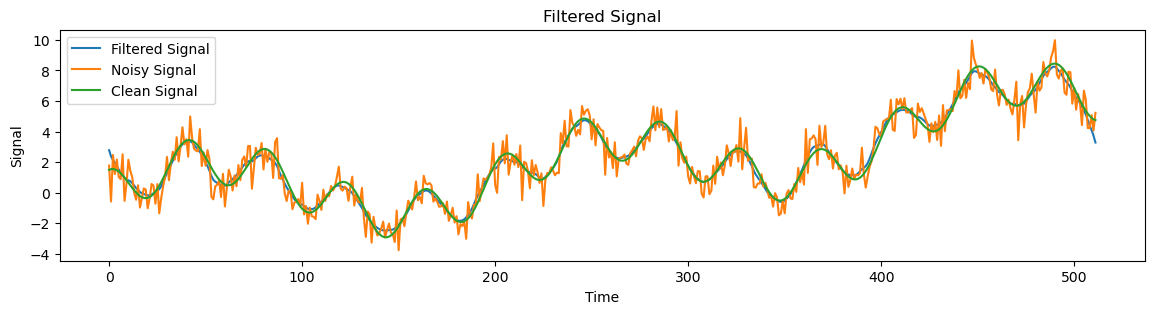

In [92]:
# Filter's parameters
alpha=0.5
div_factor = 32 # use powers of 2
win_len = int(len(time) / div_factor)
print(f"Window length: {win_len}")

# Compute window
window = signal.windows.tukey(win_len, alpha=alpha)

# Compute frequency response
response = np.fft.fft(window, len(time))
response = np.abs(response / abs(response).max())

# Apply filter
Y = (np.fft.fft(noisy_signal))
y_tukey = np.fft.ifft(Y*response)

plt.figure(figsize = [14,3])
plt.plot(y_tukey)
plt.plot(noisy_signal)
plt.plot(y_signal)
plt.title('Filtered Signal')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend(['Filtered Signal', 'Noisy Signal', 'Clean Signal'])
plt.show()

### Exercise 3

- Consider the `noisy_signal` from [Exercise 2](#exercise-2) .
- Now, your task is to recover `y_signal` using the [low-pass Butterworth filter](#butterworth-filter).
- Modify the filter order $N$ and cutoff frequency $\omega_c$ of the Butterworth filter.
- Which values seem to be the best in getting rid of the noise?

First let's compute the sampling frequency of the signals as $512/5$
- We see that the two sinusoids have a frequency of 0.5 and 2.5. We should use a butterworth filter with cutoff frequency just below those values, for example 0.4. We don't need to change N since the main issue here is to find the optimal cutoff frequency:

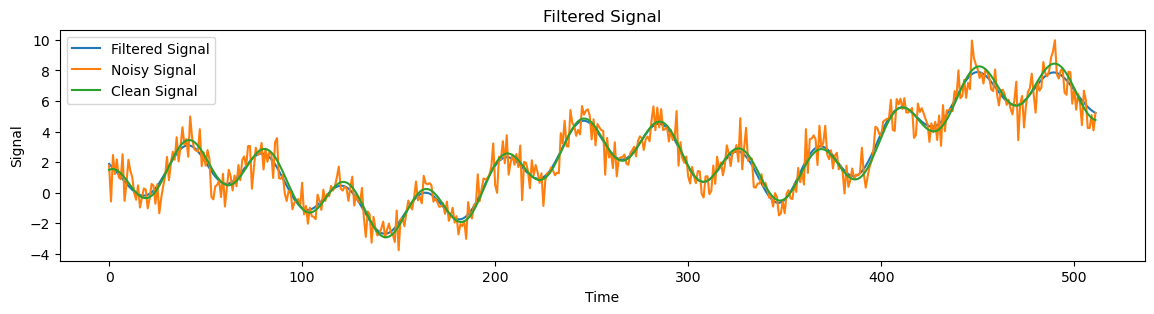

In [93]:
FS = 512/5
freq_c = 3

 # Numerator (B) and denominator (A) polynomials of the filter
B, A = signal.butter(N=6, Wn=freq_c, btype='lowpass', analog=False, fs=FS) 
# Apply the filter
y_low_butter = signal.filtfilt(B, A, noisy_signal)

plt.figure(figsize = [14,3])
plt.plot(y_low_butter)
plt.plot(noisy_signal)
plt.plot(y_signal)
plt.title('Filtered Signal')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend(['Filtered Signal', 'Noisy Signal', 'Clean Signal'])
plt.show()

### Exercise 4

- Consider the `noisy_signal` from [Exercise 2](#exercise-2).
- Now, your task is to recover `y_signal` and then remove its trend component (`y_trend`).
- To do that, you will first apply the [high-pass Butterworth filter](#high-pass-filters-hpfs).
- Optimize, by hand, the filter order $N$ and cutoff frequency $\omega_c$ of the Butterworth filter.
- Then, apply the LPF in cascade to the HPF. 
- The result should contain neither trend nor noise.

1) REMOVE THE TREND

To remove the trend we need to get rid of very low frequency components.
- We know the frequency of our sinusoids, which are 0.5 and 2.5, so we should set a cutoff value smaller than 0.5

2) REMOVE THE NOISE

To remove the noise, we can just apply the butterworth filter previously described.

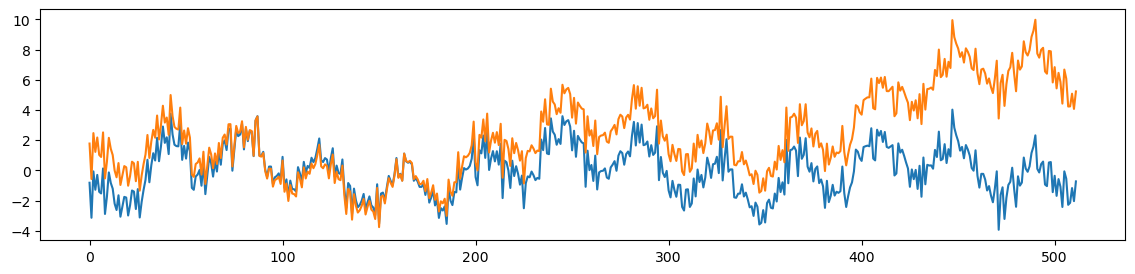

In [94]:
N = 6
omega_c = 0.4
B, A = signal.butter(N, omega_c, btype = 'highpass', output='ba', fs=FS) 
y_high_butter = signal.filtfilt(B, A, noisy_signal)
plt.figure(figsize = [14,3])
plt.plot(y_high_butter)
plt.plot(noisy_signal)




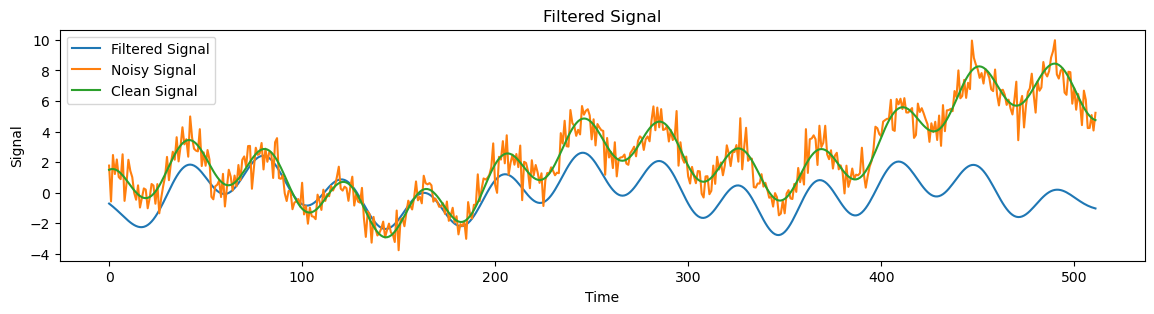

In [95]:
 # Numerator (B) and denominator (A) polynomials of the filter
B, A = signal.butter(N=6, Wn=3, btype='lowpass', analog=False, fs=FS) 
# Apply the filter
y_low_butter = signal.filtfilt(B, A, y_high_butter)

plt.figure(figsize = [14,3])
plt.plot(y_low_butter)
plt.plot(noisy_signal)
plt.plot(y_signal)
plt.title('Filtered Signal')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend(['Filtered Signal', 'Noisy Signal', 'Clean Signal'])
plt.show()

### Exercise 5

- Consider the `noisy_signal` from [Exercise 2](#exercise-2).
- Once again, your task is to recover `y_signal` and then remove its trend component (`y_trend`).
- Optimize, by hand, the filter order $N$ and the cutoff frequencies $\omega_c^\text{LOW}$ and $\omega_c^\text{HIGH}$ of the [band-pass Butterworth filter](#band-pass-filter).
- Compare the result of the BPF with what you got in [Exercise 4](#exercise-4) when you applied a HPF and LPF in cascade.

We create a bandpass filter with the cutoff frequency previously obtained. The result is exactly the same as before, just obtained in only one filter.

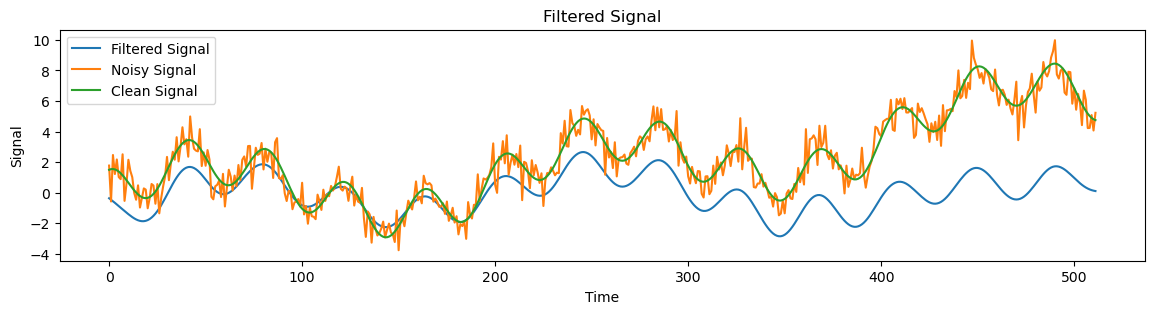

In [96]:
# Band Pass Butterworth filter
N  = 2    # Filter order
omega_c = [0.4, 3] # Cutoff frequencies
B, A = signal.butter(N, omega_c, btype = 'bandpass', output='ba', analog=False, fs=FS) 
y_band_butter = signal.filtfilt(B, A, noisy_signal)
plt.figure(figsize = [14,3])
plt.plot(y_band_butter)
plt.plot(noisy_signal)
plt.plot(y_signal)
plt.title('Filtered Signal')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend(['Filtered Signal', 'Noisy Signal', 'Clean Signal'])
plt.show()

### Exercise 6

- Consider the `noisy_signal` from [Exercise 2](#exercise-2).
- This time, you will have to remove the component `y_cos` form the signal using the [band stop filter](#band-stop-filter).

To remove only the y_cos, let's create a band stop filter around the frequency of the cosine (2.5):

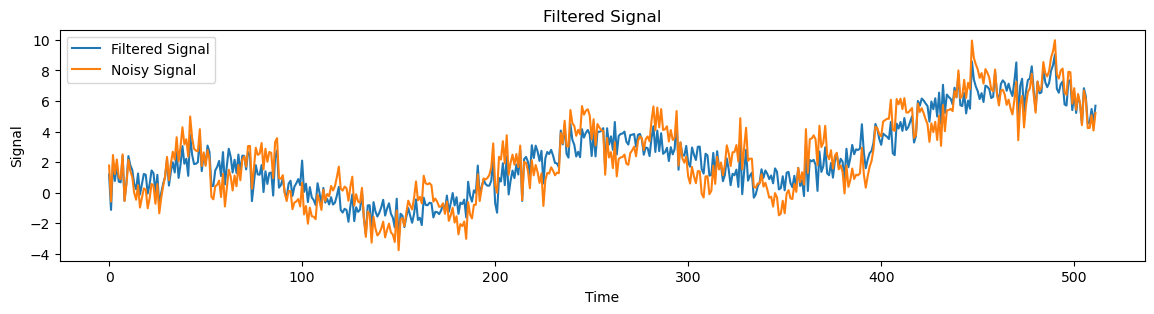

In [97]:
omega_c = [2, 3] # Cutoff frequencies
B, A = signal.butter(N, omega_c, btype = 'bandstop', output='ba', analog=False, fs=FS) 
y_bandstop_butter = signal.filtfilt(B, A, noisy_signal)
plt.figure(figsize = [14,3])
plt.plot(y_bandstop_butter)
plt.plot(noisy_signal)
plt.title('Filtered Signal')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend(['Filtered Signal', 'Noisy Signal'])
plt.show()

### Exercise 7

- Consider the CO2 data defined [here](#forecast-example-2).
- Divide the data in training and test.
- Identify the optimal number of harmonics that gives the best MSE on the test set.

Best number of harmonics: 16


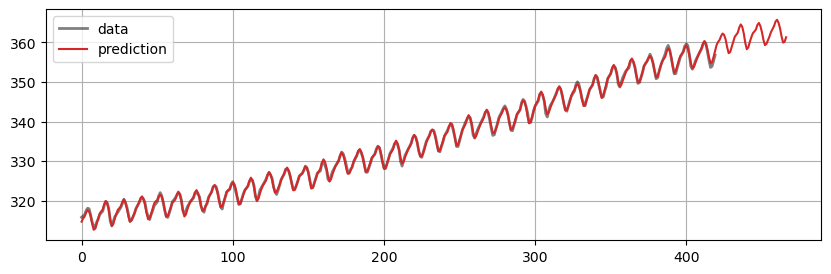

In [ ]:
co2 = sm.datasets.get_rdataset("co2", "datasets").data

# Convert decimal year to pandas datetime
def convert_decimal_year_to_datetime(decimal_years):
    dates = [(pd.to_datetime(f'{int(year)}-01-01') + pd.to_timedelta((year - int(year)) * 365.25, unit='D')).date() 
             for year in decimal_years]
    return dates
co2['time'] = convert_decimal_year_to_datetime(co2['time'])

# Convert the column ds to datetime
co2['time'] = pd.to_datetime(co2['time'])

# Resample to monthly frequency based on the ds column
co2 = co2.resample('MS', on='time').mean().reset_index()

# Replace NaN with the mean of the previous and next value
co2['value'] = co2['value'].interpolate()
total_len = len(co2['value'])

# Train/test split
train = co2['value'][:420]
test = co2['value'][421:]

test_mse = []
for i in range(1,1000):
    prediction = fourierPrediction(train, n_predict=47, n_harm=i)
    #fourierPredictionPlot(train, prediction)
    test_mse.append(np.mean((test - prediction[420:])**2))

best_harm = np.argmin(test_mse)
print(f"Best number of harmonics: {best_harm+1}")
print(f"Best MSE: {test_mse[best_harm]}")
plt.figure(figsize=(10, 3))
prediction = fourierPrediction(train, n_predict=47, n_harm=best_harm+1)
fourierPredictionPlot(train, prediction)